<a id="top"></a>
# Vegetation Change

This notebook uses changes in NDVI to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, warnings
import xarray as xr
from matplotlib.cm import RdYlGn

sys.path.append('../Scripts')

from odc.algo import reshape_for_geomedian, to_f32, from_float, xr_geomedian

from deafrica_bandindices import calculate_indices
from deafrica_classificationtools import HiddenPrints
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard, mostcommon_crs, calc_geomedian
from deafrica_plotting import display_map, map_shapefile, rgb
from deafrica_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
dc = datacube.Datacube(app='mining')
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34187 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [3]:
# Select an analysis region 
# Consider using Cloud Statistics notebook to find clear scenes

# Mining Region near Obuasi, Ghana - LARGE
# Run case from 2015 (year) thru 2019 (first 3 months)
# latitude = (6.0985, 6.2675)
# longitude = (-2.050, -1.8629)

# Mining Region west of Obuasi, Ghana - SMALL
# Run case from 2015 (year) thru 2019 (first 3 months)
# latitude = (6.2286, 6.2822)
# longitude = (-1.9324, -1.8871)

# Ankobra River Basin = Prestia Sample
# Time periods = 29-Dec-2015 to Jan-2018
# latitude = (5.4458, 5.5258)
# longitude = (-2.1792, -2.0886)

# Ankobra River Basin = Entire Bounding Region
# lat_range = (5.198, 5.695)
# lon_range = (-2.275, -1.750)


lat_range = (6.370517, 6.287974)
lon_range = (-1.907504, -1.832074)


In [4]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(lon_range, lat_range)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [5]:
# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = 2013

# Select the analysis time period (start and end)
analysis_time_period = 2019

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses

baseline_mosaic_function = "median" 
analysis_mosaic_function = "median" 

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [6]:
#Create a query object

query = {
    'x': lon_range,
    'y': lat_range,
    'group_by': 'solar_day',
    'resolution': (-30, 30),
  'align': (15, 15),
   #'measurements' : ["red", "green", "blue", "nir", "swir1", "swir2"]
}
products = ["ls8_usgs_sr_scene"]
# find the right crs for the location
crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

query['time'] = (baseline_time_period)
baseline_ds = load_ard(dc=dc, products=products, output_crs=crs, min_gooddata=0.70, **query)

query['time'] = (analysis_time_period)
analysis_ds = load_ard(dc=dc, products=products, output_crs=crs, min_gooddata=0.70, **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 1 out of 11 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps
Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 8 out of 136 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 8 time steps


In [7]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
baseline_ds_scaled = to_f32(baseline_ds, scale=scale, offset=offset)
baseline_ds_geomedian = xr_geomedian(baseline_ds_scaled, num_threads=1, eps=1e-7, nocheck=True)
baseline_ds_geomedian = baseline_ds_geomedian.compute()
baseline_ds_geomedian = from_float(baseline_ds_geomedian, dtype='float32', nodata=np.nan, scale=1/scale,  offset=-offset/scale)


analysis_ds_scaled = to_f32(analysis_ds, scale=scale, offset=offset)
analysis_ds_geomedian = xr_geomedian(analysis_ds, num_threads=1, eps=1e-7, nocheck=True)
analysis_ds_geomedian = analysis_ds_geomedian.compute()
analysis_ds_geomedian = from_float(analysis_ds_geomedian, dtype='float32', nodata=np.nan, scale=1/scale,  offset=-offset/scale)

In [8]:
baseline_ds_geomedian = calculate_indices(baseline_ds_geomedian, ['NDVI'], collection='c1')
analysis_ds_geomedian = calculate_indices(analysis_ds_geomedian, ['NDVI'], collection='c1')

## Create a Mosaic for the Baseline and Analysis Time Periods

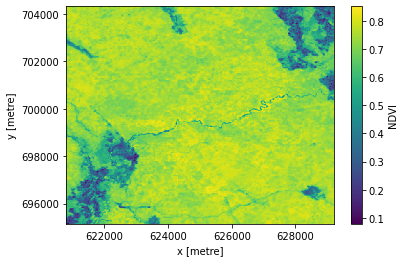

In [9]:
analysis_ds_geomedian.NDVI.plot()

## <span id="anomalies">Calculate Anomaly Product [&#9652;](#top)</span>  

In [10]:
parameter_anomaly = analysis_ds_geomedian.NDVI - baseline_ds_geomedian.NDVI

## Show Baseline RGB, Analysis RGB and Anomaly Products

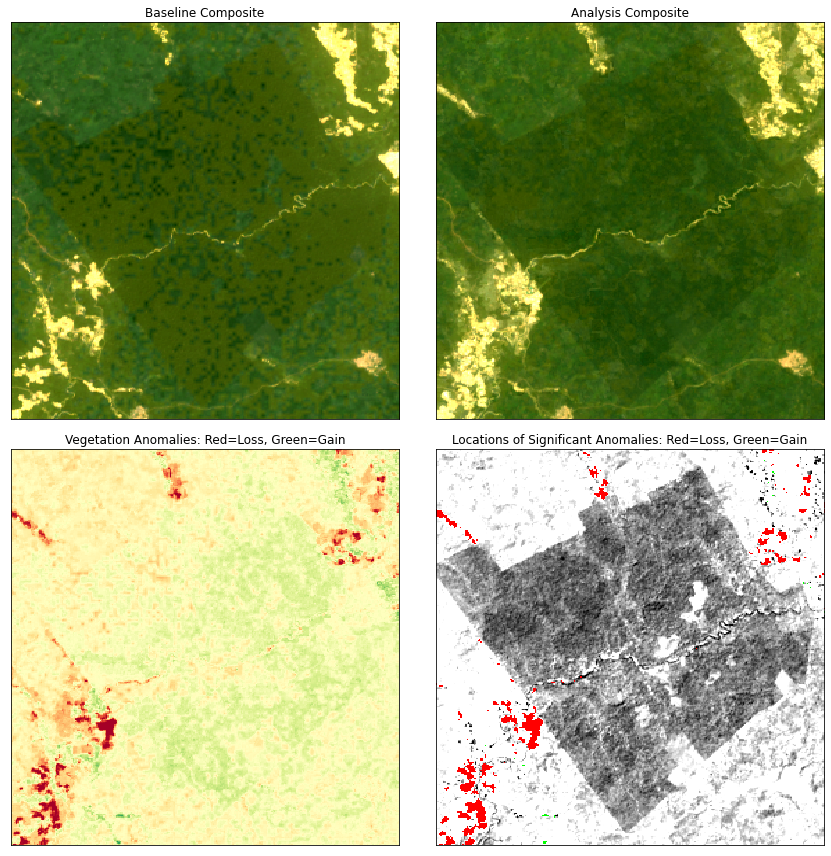

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))


# Use the middle values of the data (2% to 98%) to brighten the image

baseline_rgb = baseline_ds_geomedian[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_ds_geomedian[['red', 'green', 'blue']].to_array()


lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values, analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values, analysis_rgb.quantile(up_qtl).values)
# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold

## Plot #1 = Baseline RGB (upper left)
baseline_rgb.plot.imshow(ax=ax[0,0], vmin=baseline_rgb.quantile(lw_qtl).values, vmax=baseline_rgb.quantile(up_qtl).values)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=analysis_rgb.quantile(lw_qtl).values, vmax= analysis_rgb.quantile(up_qtl).values)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1, 0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_ds_geomedian[plt4_bkg_band].values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(analysis_ds_geomedian[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_ds_geomedian[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Extreme anomaly overlays
loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_ds_geomedian.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr, name='rgb', dims=['rgb'], coords={'rgb': rgb_coord_arr})

plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, dims=['y','x','rgb'],  coords=plt4_coords)
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Calculate Pixel Counts within Thresholds

In [12]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [13]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# NDVI losses are typically <0.2 for deforestation
minimum_change = -0.7
maximum_change = -0.2

In [14]:
# This output is a count of the pixels that fall within each threshold range
threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 85680, 'total_non_cloudy': 85680, 'inside': 1441, 'outside': 84239}

In [15]:
# This output is a percentage of the pixels that fall within each threshold range
threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 1.6818394024276377,
 'percent_outside_threshold': 98.31816059757236,
 'percent_clouds': 0.0}